This is a notebook to analyse neural responses to sound presentations. 
Ephys data is recorded using openEphys
Sound presentation is done with bpod and matlab
During sound presentation a ttl is sent to openEphys from bpod itself

In [1]:
# Add modules to the path
import sys
sys.path.insert(0, '/mnt/c/Users/herny/OneDrive/Documents/GitHub/')

In [2]:
# Import helpers
from BehaviouralAnalysis.utils import data_reader
from BehaviouralAnalysis.utils.plot_utils import axvlines
import pyopenephys
import matplotlib.pylab as plt
from utils.custom_functions import getFirstPulses
import numpy as np
from scipy.signal import argrelextrema
import time
import pickle
from scipy.signal import butter, filtfilt


<br><br>Behavioural data

In [3]:
# Behavioral data
BehavPath = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'
BehavFilePath = 'Green/Sound_Presentation/Session Data/Green_Sound_Presentation_20190305_101010.mat'
Behav_Data_Dict = data_reader.Bpod_Sound_Presentation(BehavPath + BehavFilePath)


In [4]:
stimulus_order = Behav_Data_Dict['Stimulus']

###### <br><br>Ephys data

1. Referencing
2. High-pass filter 6/900-6000
2. Thresholding (uV (e.g. >25uV), SD, ...)
3. "Censoring" -> Imposing a refractory period to not find spikes twice (300us)

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [6]:
OEpath = '/mnt/c/Users/herny/Desktop/SWC/Data/Ephys_data/SoundResponses/'
Experiment = 'Green_2019-04-01_17-58-44_SoundResponses'
OEfile = pyopenephys.File(OEpath + Experiment)

Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format


In [7]:
recording = OEfile.experiments[0].recordings[0]
print('Duration: ', recording.duration)
print('Sampling Rate: ', recording.sample_rate)

.dat:  continuous.dat
Estimated samples:  37759488  Numchan:  35
Duration:  1258.6495666666667 1/Hz
Sampling Rate:  30000.0 Hz


In [8]:
BpodTTLs = recording.events[0].times
AnalogSignals = recording.analog_signals[0]

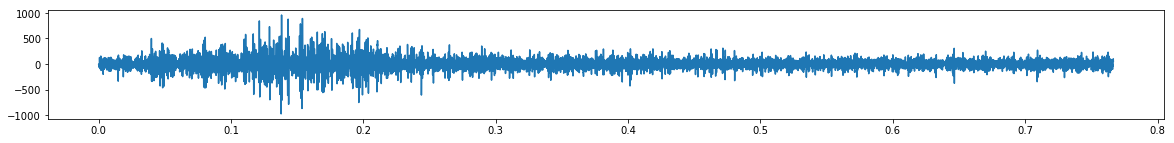

In [9]:
# plot analog signal of channel 4
fig_an, ax_an = plt.subplots(figsize=(20, 2))
#ax_an.plot(AnalogSignals.times[30000:31000], AnalogSignals.signal[3][30000:31000])
b,a = butter_bandpass(900, 6000, 30000)
filtered = filtfilt(b, a, AnalogSignals.signal[3])
ax_an.plot(AnalogSignals.times[1:23000], filtered[1:23000])
#axvlines(BpodTTLs)
#plt.xlim(200, 200.1)
plt.show()


In [10]:
#Detect first events (separated by at least 5 seconds)
soundPresentationTimes  = getFirstPulses(BpodTTLs, 5)

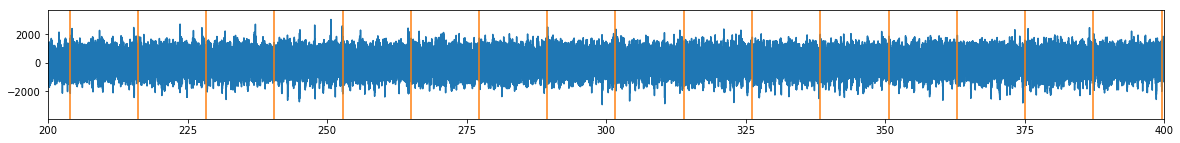

In [11]:
# plot first pulses
fig_an, ax_an = plt.subplots(figsize=(20, 2))
ax_an.plot(AnalogSignals.times, AnalogSignals.signal[3])
axvlines(soundPresentationTimes)
plt.xlim(200, 400)
plt.show()

<br><br>Check that datasets match

In [12]:
if len(soundPresentationTimes) == len(stimulus_order):
    print('Datasets match')
else:
    print('Datasets do not match!!!')
    

Datasets match


<br><br>Get spikes from the ephys data

In [13]:
# Calculate the median of all channels
MedianSignal = np.median(AnalogSignals.signal[range(32)], axis = 0)

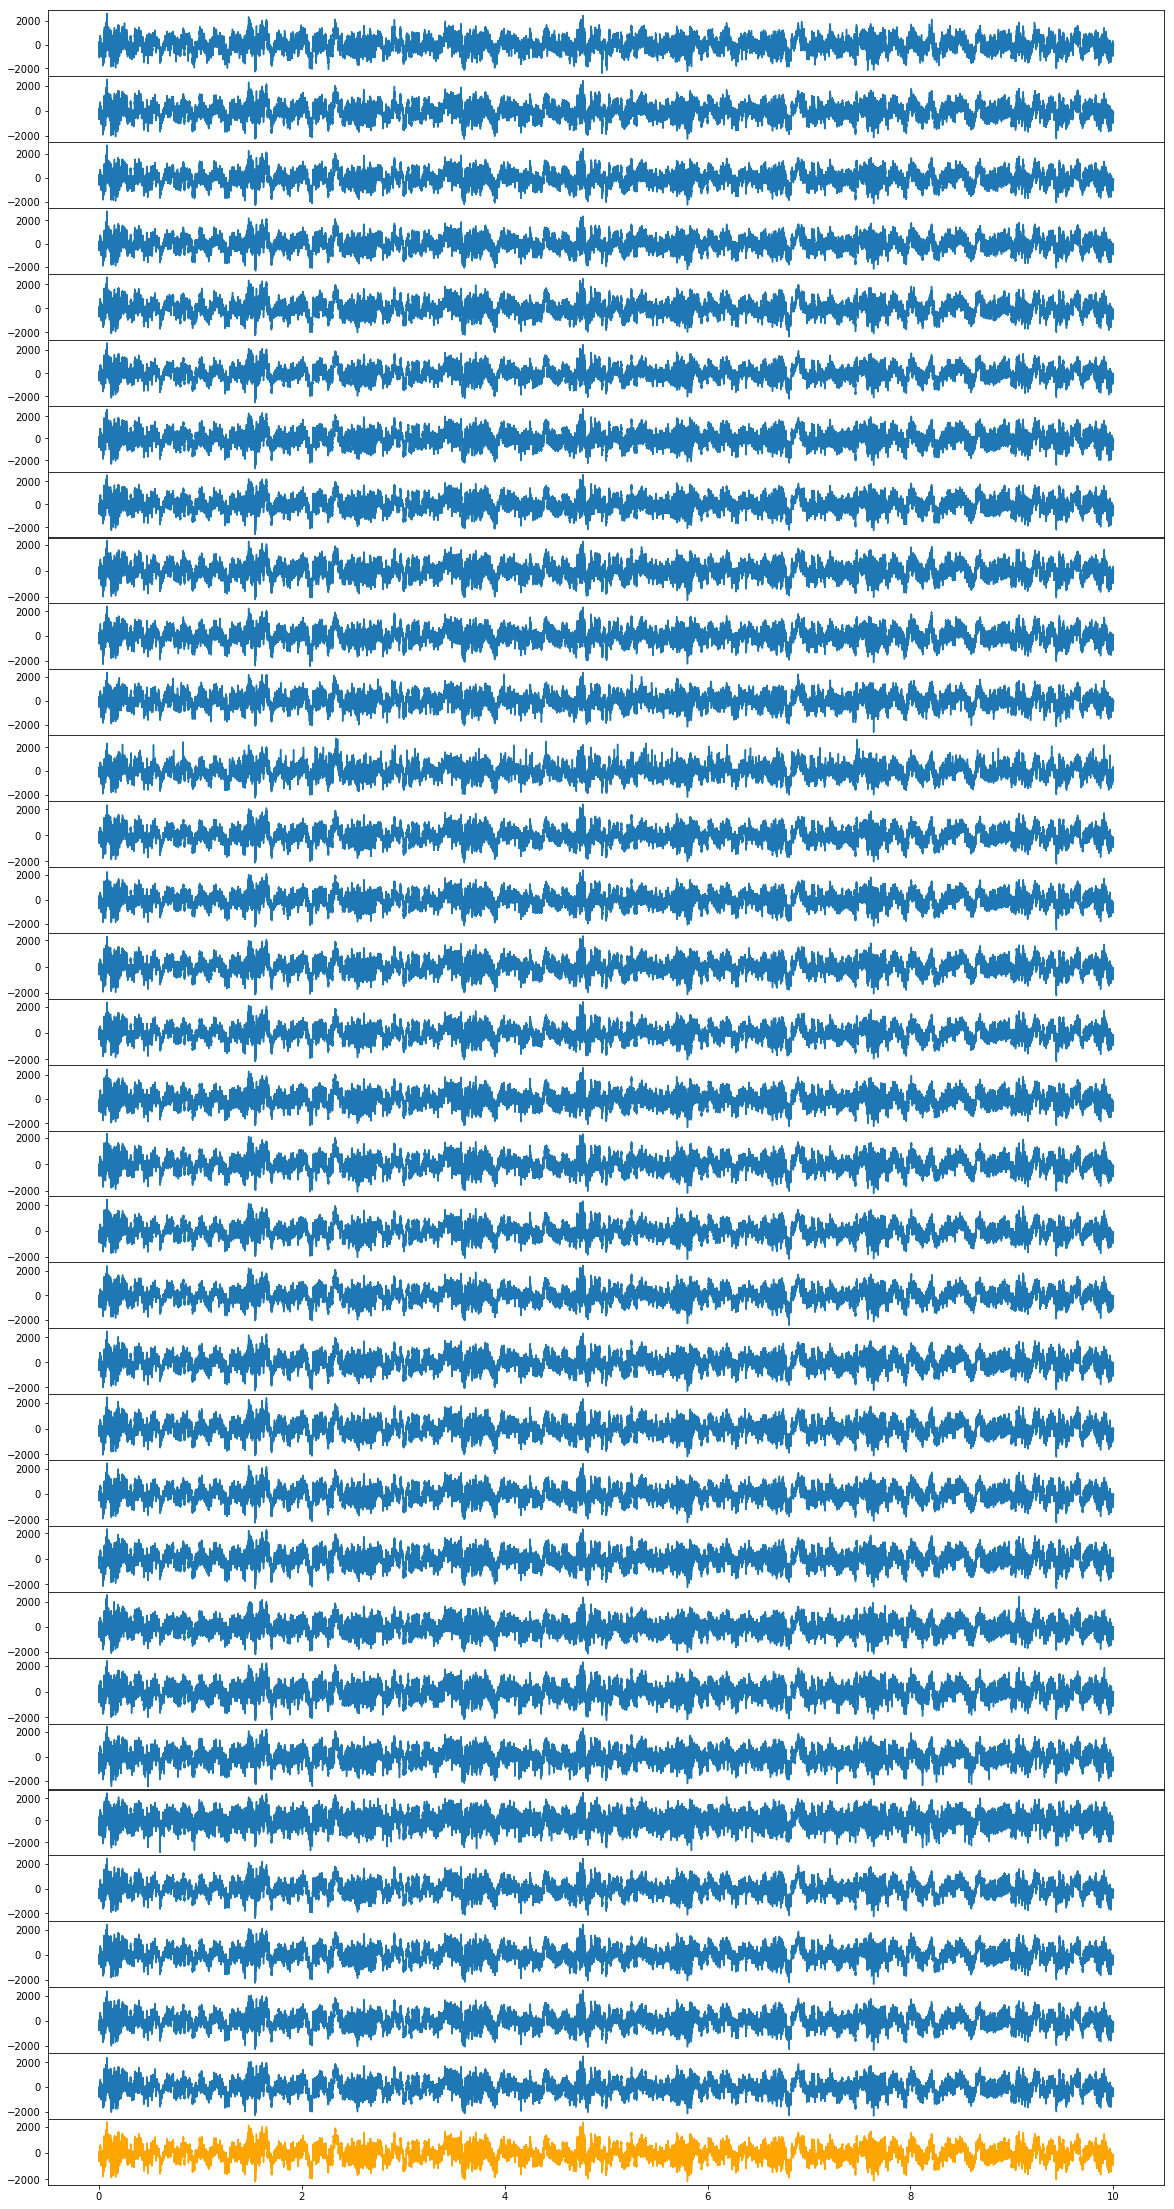

In [14]:
# Plot all channels and the median
PlotX = range(0,300000)

fig, axs = plt.subplots(33, 1, figsize=(20, 40) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    axs[i].plot(AnalogSignals.times[PlotX], AnalogSignals.signal[i][PlotX])
    #axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)
    
    #print(i)
axs[i+1].plot(AnalogSignals.times[PlotX], MedianSignal[PlotX], color = 'orange')
plt.show()

In [15]:
# Subtract the median from all channels
RefSignals = AnalogSignals.signal - MedianSignal

In [16]:
# Band-pass filter the data
RSfilt = [None] * len(AnalogSignals.signal)
b,a = butter_bandpass(900, 6000, 30000)
for row in range(len(AnalogSignals.signal)):
    RSfilt[row] = filtfilt(b, a, RefSignals[row])
    print(row)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [17]:
# Compute the standard deviation of every channel
RefSignalsSD = [None] * 32
for i in range(32):
    RefSignalsSD[i] = np.std(RSfilt[i])

In [18]:
# Theshold cut-off
SD_cutoff = 4.5

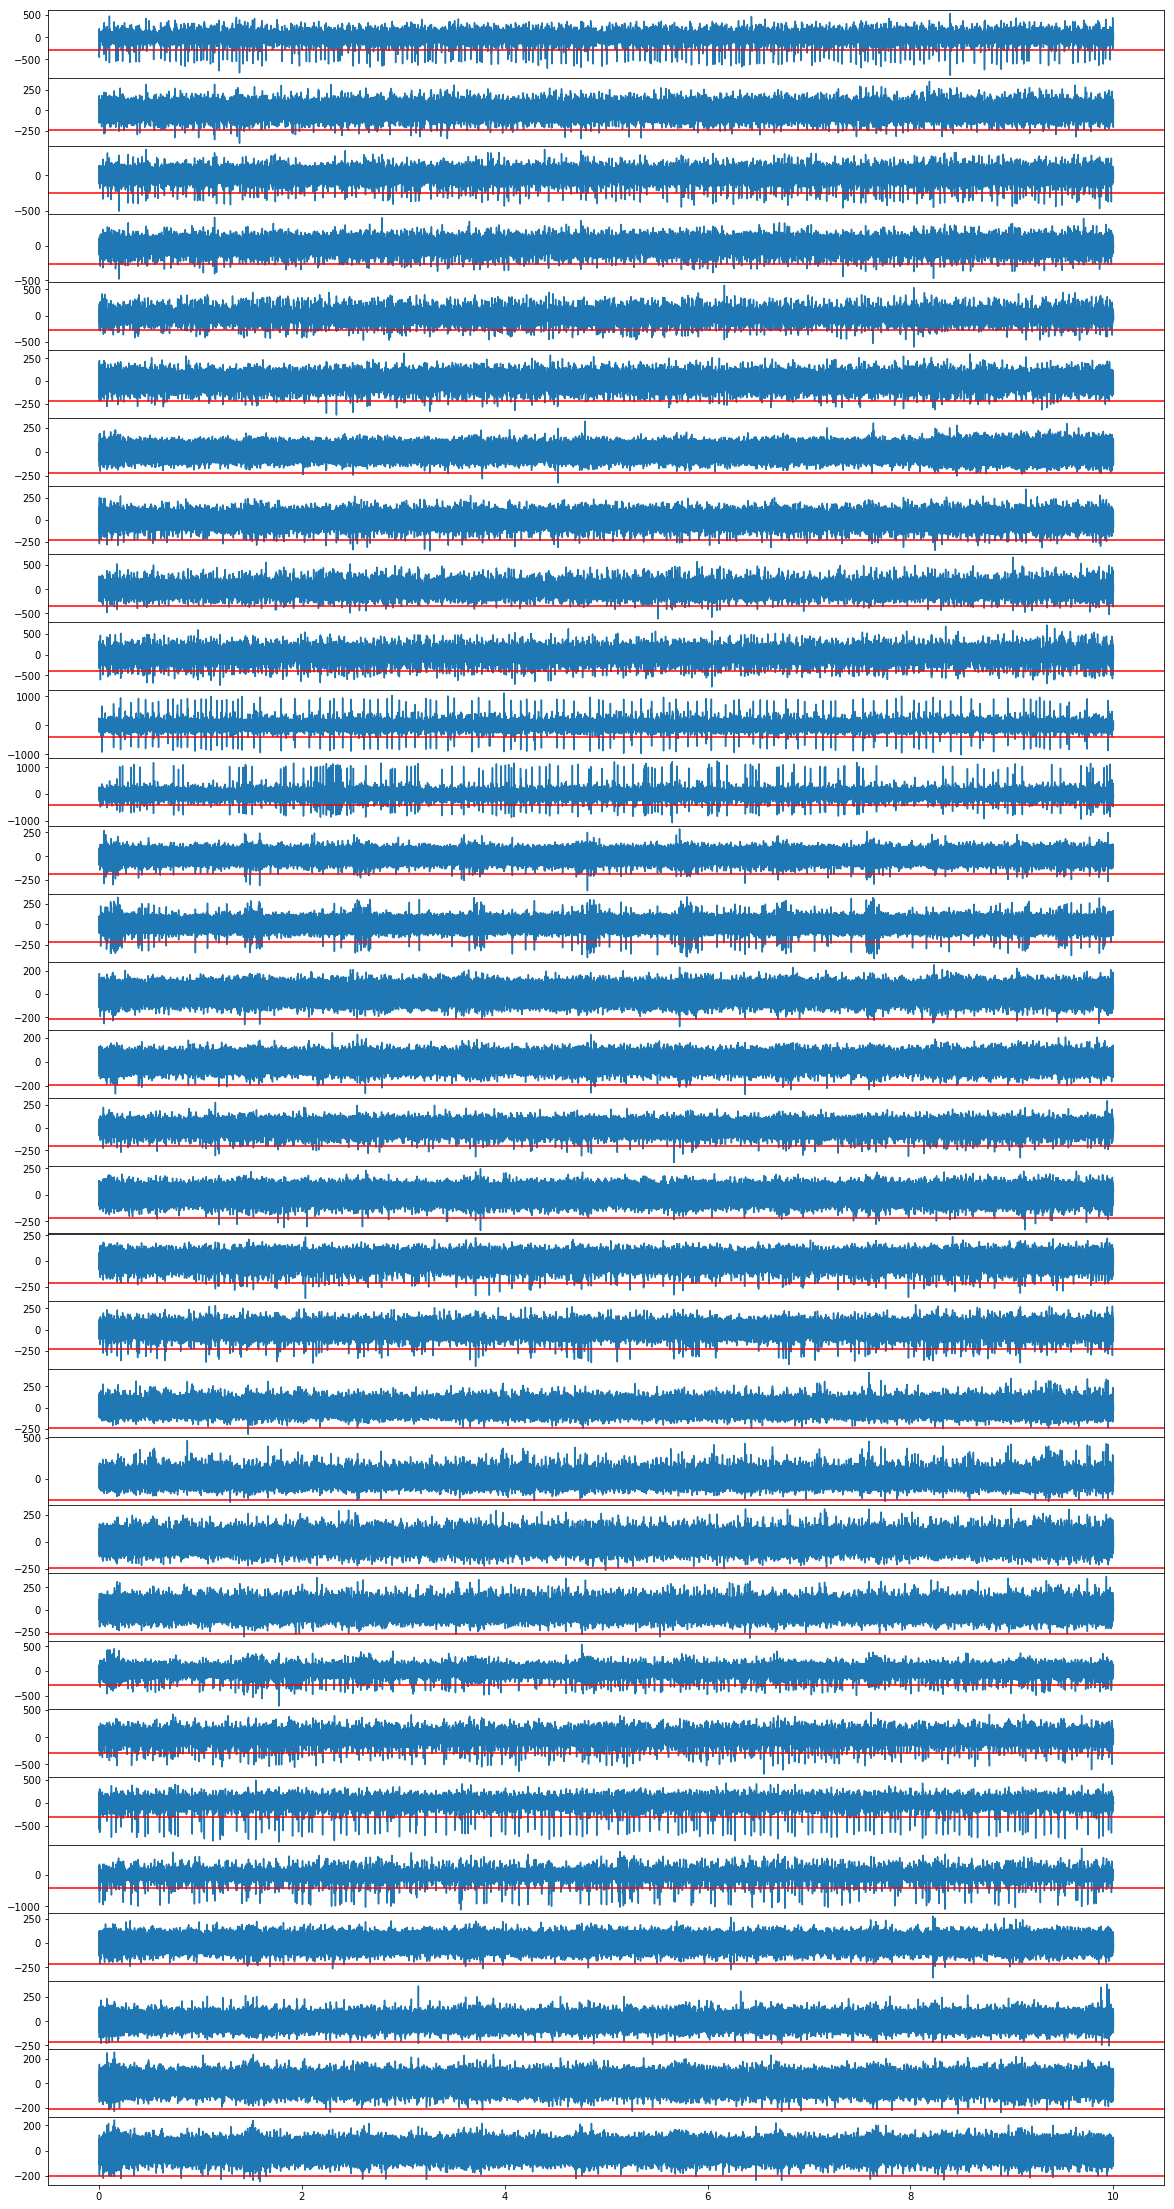

In [19]:
# Plot
PlotX = range(0,300000)
fig, axs = plt.subplots(32, 1, figsize=(20, 40) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    axs[i].plot(AnalogSignals.times[PlotX], RSfilt[i][PlotX])
    #axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)
    # plot SD
    #axs[i].axhline(SD_cutoff*RefSignalsSD[i], color = 'red')
    axs[i].axhline(-SD_cutoff*RefSignalsSD[i], color = 'red')
    
    #print(i)
plt.show()

In [20]:
# Detect threshold crossings
start = time.time()
SignalsSpikes = [None] * 32

for Channel in range(32):
    # Get the time points above/below the cutoff
    #SigMaxIdx = argrelextrema(Channel, np.greater)
    Crossings = AnalogSignals.times[(RSfilt[Channel])<-SD_cutoff*RefSignalsSD[Channel]]

    # Get the first events in less than 1ms
    if len(Crossings)>0:
        SignalsSpikes[Channel] = getFirstPulses(Crossings, 0.001)
    
    print(Channel)
    
print(start - time.time())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
-179.54959511756897


In [21]:
# Save the data
# Saving the objects:
with open(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '.pkl', 'wb') as f:
    pickle.dump([MedianSignal, RefSignalsSD, SignalsSpikes], f)

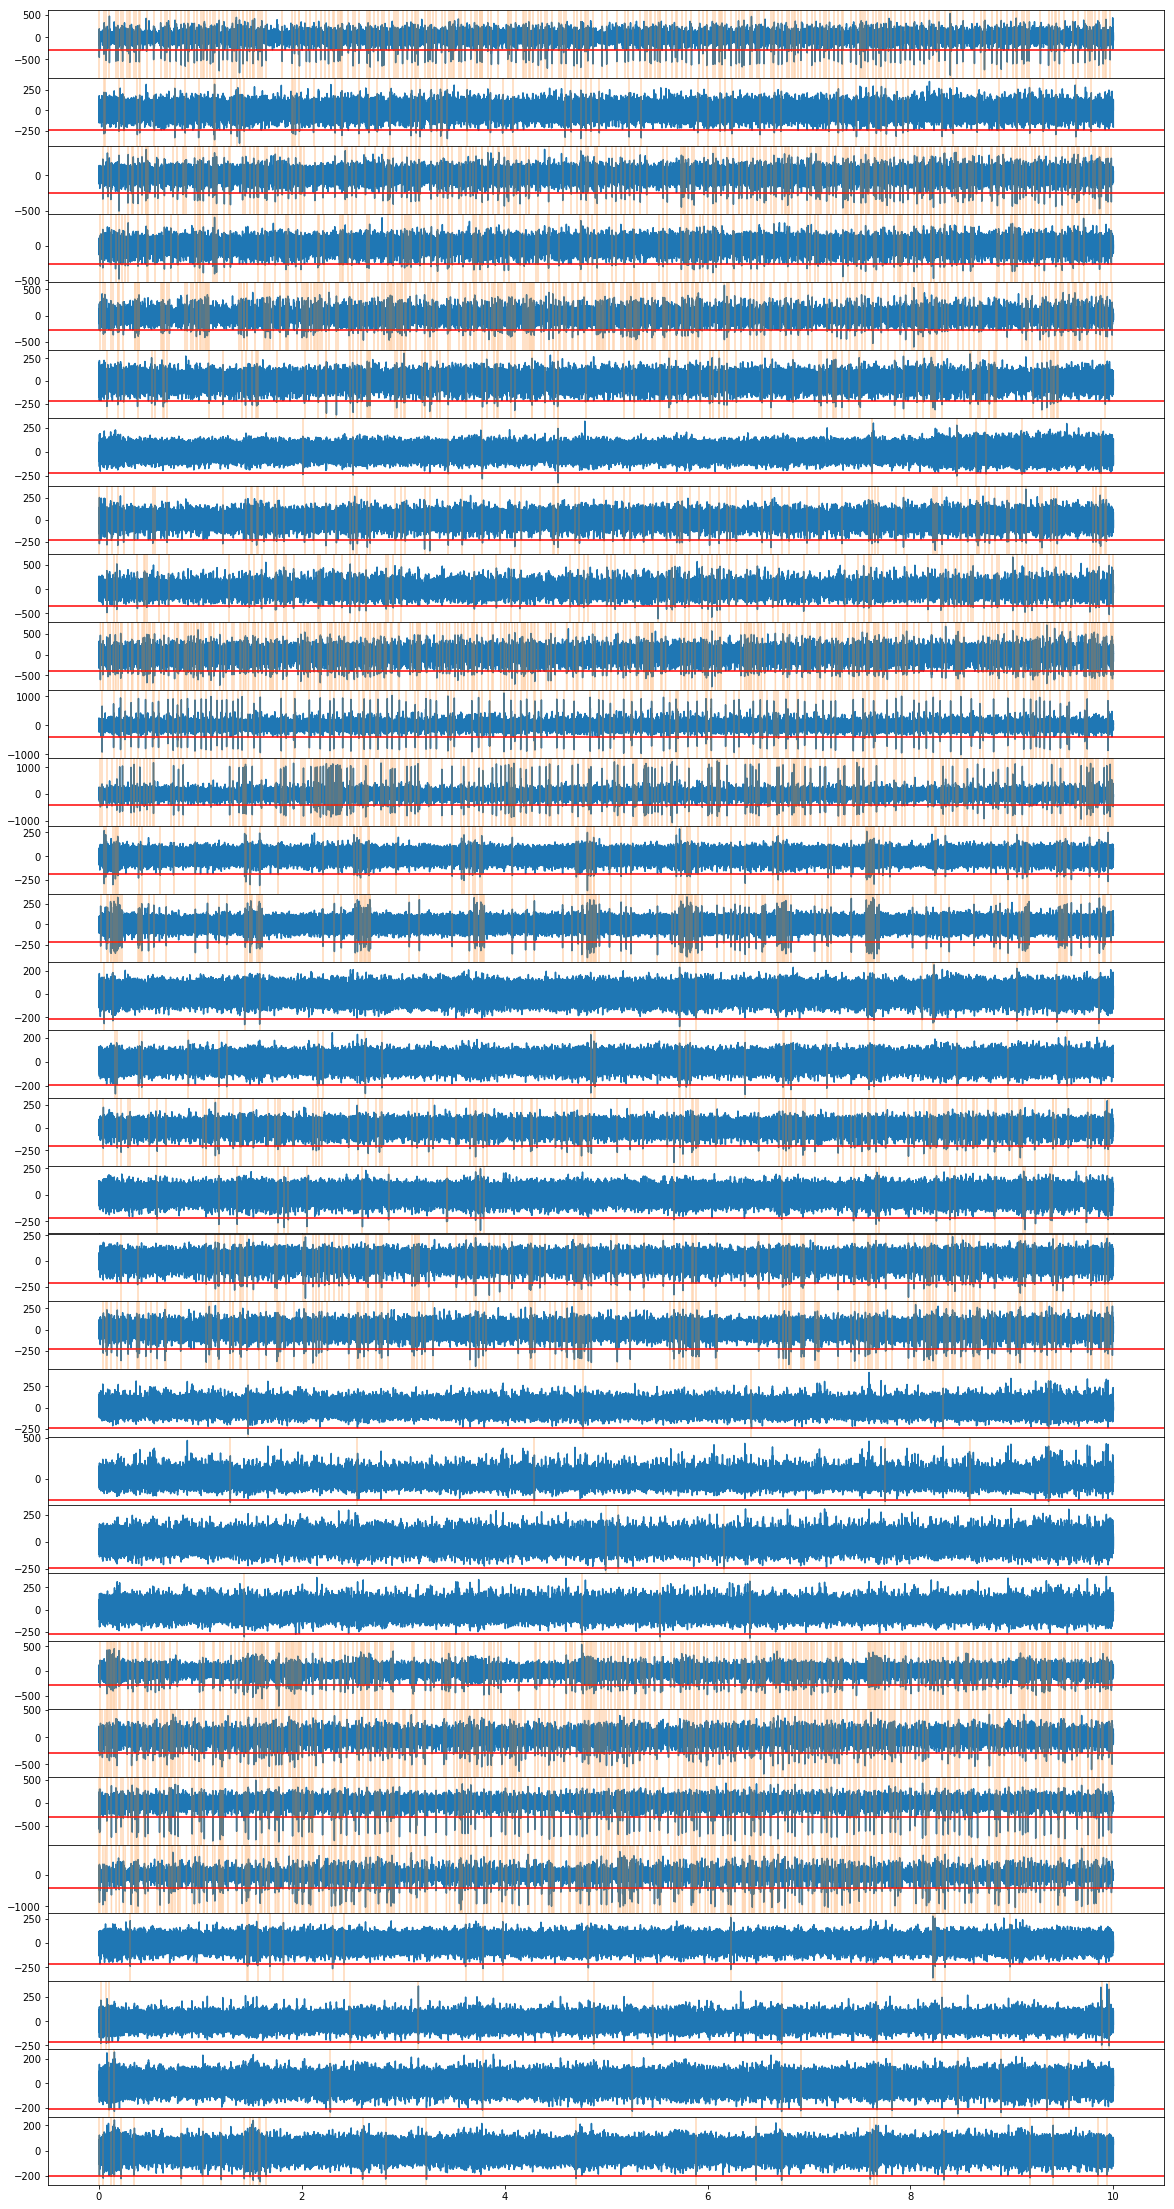

In [22]:
# Plot
PlotX = range(0,300000)
fig, axs = plt.subplots(32, 1, figsize=(20, 40) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    axs[i].plot(AnalogSignals.times[PlotX], RSfilt[i][PlotX])
    #axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)
    # plot SD
    #axs[i].axhline(SD_cutoff*RefSignalsSD[i], color = 'red')
    axs[i].axhline(-SD_cutoff*RefSignalsSD[i], color = 'red')
    axvlines(SignalsSpikes[i][(SignalsSpikes[i]>=AnalogSignals.times[PlotX][0]) & (SignalsSpikes[i]<=AnalogSignals.times[PlotX][-1])], alpha=0.3, ax = axs[i])
    #print(i)
plt.show()

In [23]:
# Getting back the objects:
with open(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '.pkl', 'rb') as f:
    MedianSignal, RefSignalsSD, SignalsSpikes = pickle.load(f)

<br><br>Create tuning curves

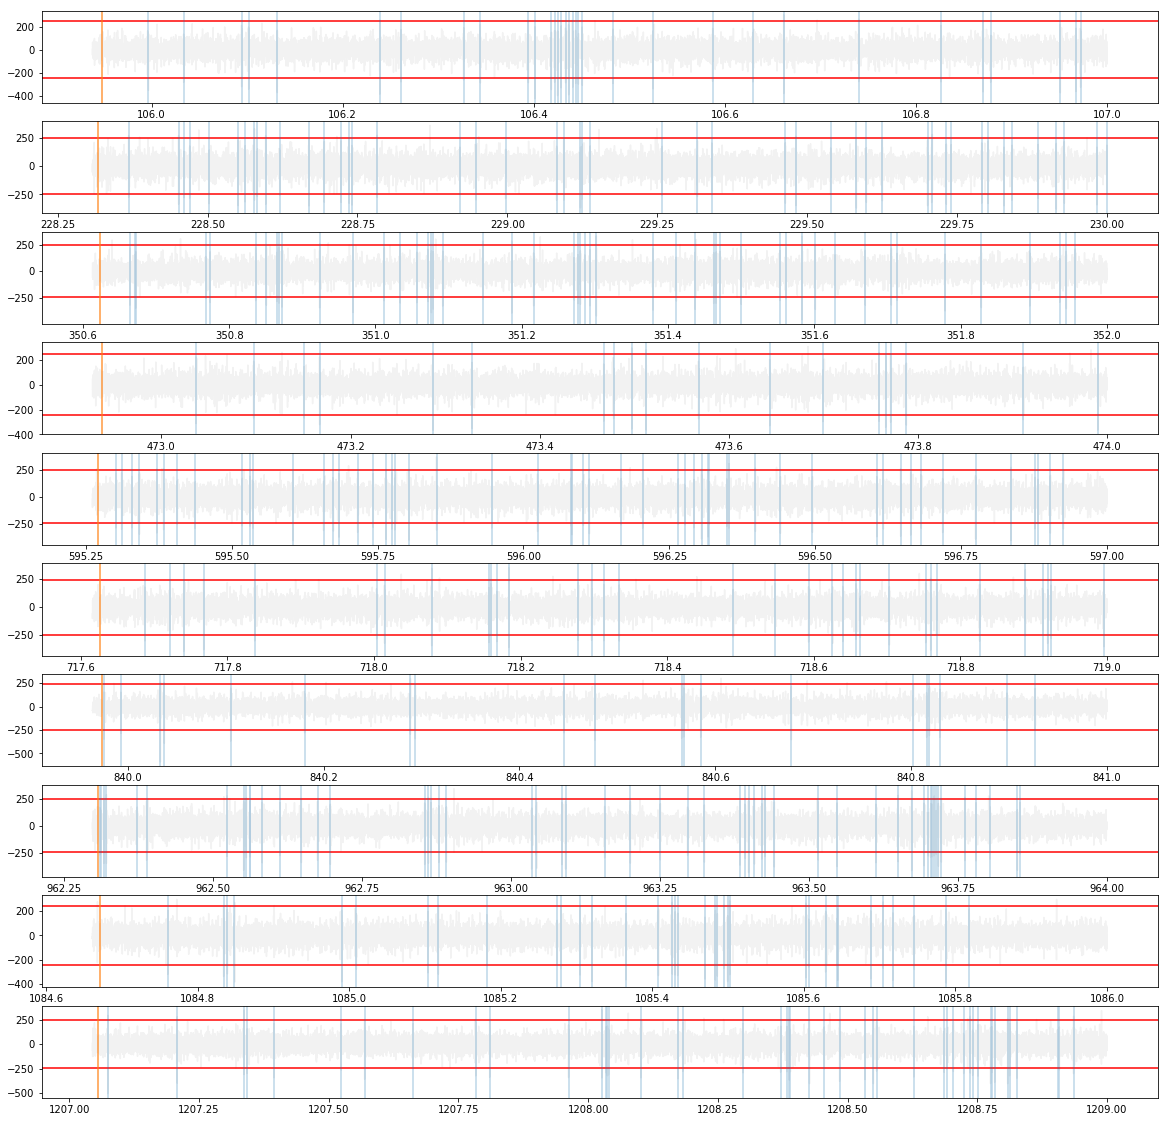

In [24]:
# plot a channel after the presentation of a sound
SecAfterSound = 2
SoundID = 9
Channel = 2
nSounds = 10


SoundTimes = soundPresentationTimes[stimulus_order==SoundID][0:nSounds]


fig, axs = plt.subplots(nSounds, 1, figsize=(20, 2*nSounds) , facecolor='w', edgecolor='k', sharex=False)
fig.subplots_adjust(hspace = 0.2, wspace=.001)
#axs = axs.ravel()

for i in range(nSounds):
    PlotX = range(int(30000*(SoundTimes[i].item()-0.01)), 30000*(int(SoundTimes[i].item()+SecAfterSound)))
    axs[i].plot(AnalogSignals.times[PlotX], RSfilt[Channel][PlotX], alpha = 0.1, color = 'grey')
    axs[i].axhline(SD_cutoff*RefSignalsSD[Channel], color = 'red')
    axs[i].axhline(-SD_cutoff*RefSignalsSD[Channel], color = 'red')
    axvlines(SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[PlotX][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[PlotX][-1])], alpha=0.3, ax = axs[i])
    axvlines(SoundTimes[(SoundTimes>=AnalogSignals.times[PlotX][0]) & (SoundTimes<=AnalogSignals.times[PlotX][-1])], alpha=0.8, ax = axs[i])
    #print(i)
plt.show()

In [25]:
# Calculate the spike times per sound ID and per channel aligned to the sound presentation

# Create a structure to hold the spikes: SpikesAligned[Channel][SoundID][nPresentation] -> list of spike times in window
SecBeforeSound = 0.1
SecAfterSound = 0.2
SpikesAligned = [None] * 32
repOrSounds = len(stimulus_order)/len(set(stimulus_order))
Arr_unique, Arr_counts = np.unique(stimulus_order, return_counts=True)

for Channel in range(len(SpikesAligned)):
    SoundIDcounts = [None] * len(set(stimulus_order))
    for SoundID in set(stimulus_order):
        SoundIDidx = int(np.where(Arr_unique==SoundID)[0])
        Counts = [None] * Arr_counts[SoundIDidx]
        for i in range(len(Counts)):
            SoundTime = soundPresentationTimes[stimulus_order==SoundID][i]
            calcWindow = range(int(30000*(SoundTime.item()-SecBeforeSound)), int(30000*(SoundTime.item()+SecAfterSound)))
            Counts[i] = SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[calcWindow][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[calcWindow][-1])] - SoundTime           
            
        SoundIDcounts[SoundIDidx] = Counts
    SpikesAligned[Channel] = SoundIDcounts
            

In [26]:
# create a general raster plot, removing spikes that ocurred after .3ms of another spike occurrence
# join the spikes of all electrodes
Raster = [None] * 100 # 10 sounds 10 times
counter = 0
for SoundID in range(len(SpikesAligned[0])):
    for nPres in range(len(SpikesAligned[0][0])):
        concVector = np.concatenate([item[SoundID][nPres] for item in SpikesAligned])
        Raster[counter] = getFirstPulses(np.sort(concVector), 0.0003)     
        counter += 1   

In [27]:
# Create fake data to check that the plotting


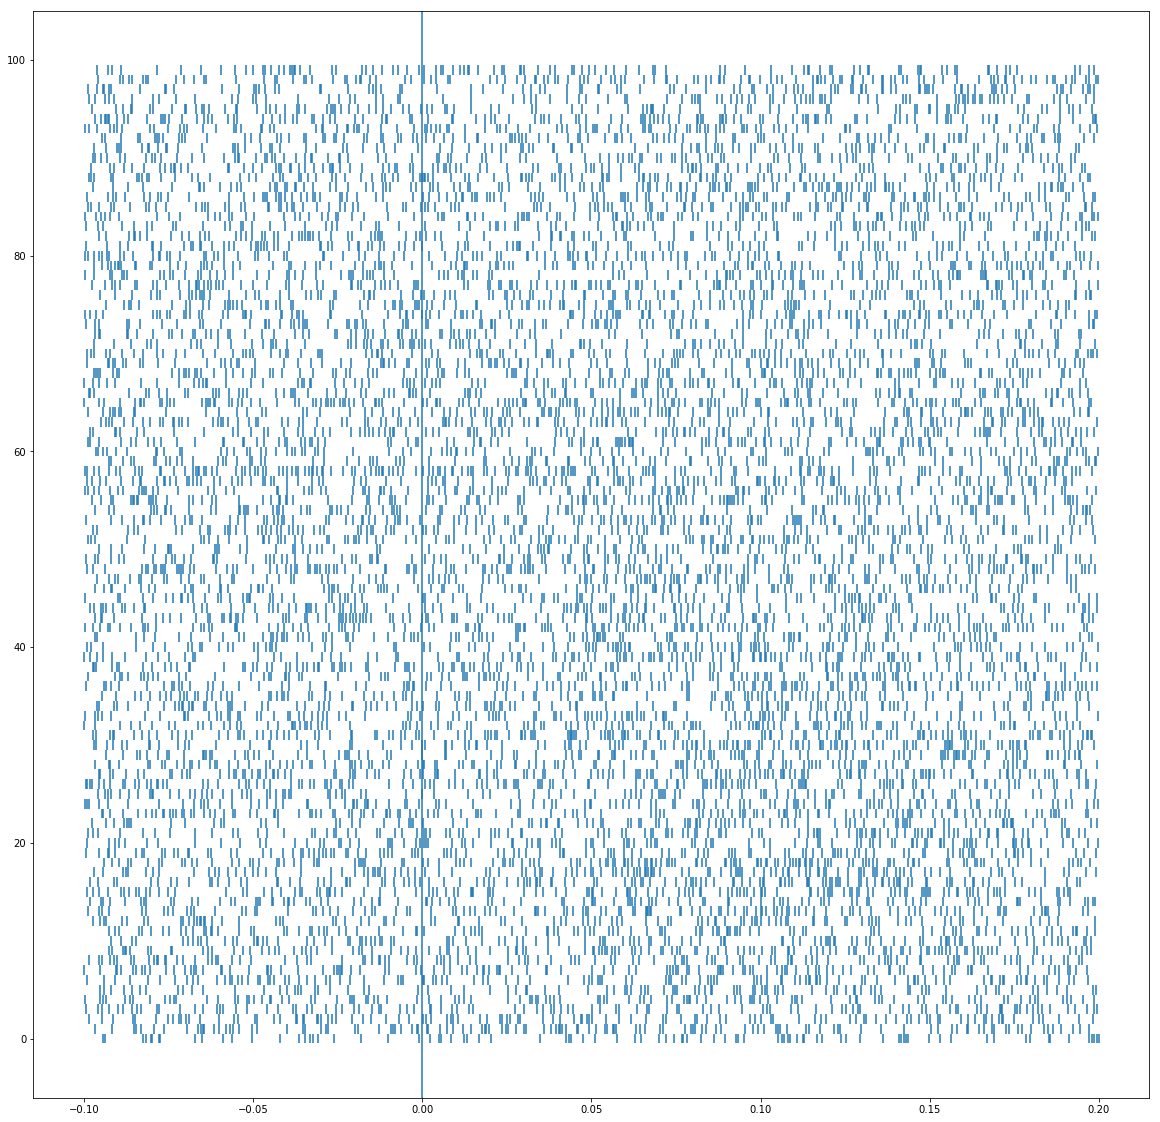

In [28]:
# plot
fig_an, ax_an = plt.subplots(figsize=(20, 20))
ax_an.eventplot(Raster)
axvlines(0)
plt.savefig(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '_raster.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [29]:
# Split the data by tetrode
# assumes they are in order
tetrodeList = np.arange(32).reshape(8,4)

# create a general raster plot, removing spikes that ocurred after .3ms of another spike occurrence
# join the spikes of all electrodes
RasterList = [None] * len(tetrodeList)
counter2 = 0
for tetrode in tetrodeList:
    Raster = [None] * 100 # 10 sounds 10 times
    counter = 0
    for SoundID in range(len(SpikesAligned[0])):
        for nPres in range(len(SpikesAligned[0][0])):
            TetSpikes = [SpikesAligned[i] for i in tetrode]
            concVector = np.concatenate([item[SoundID][nPres] for item in TetSpikes])
            if len(concVector) > 0:
                Raster[counter] = getFirstPulses(np.sort(concVector), 0.0003)
            else:
                Raster[counter] = []
                    
            counter += 1   
    RasterList[counter2] = Raster
    counter2 += 1

5


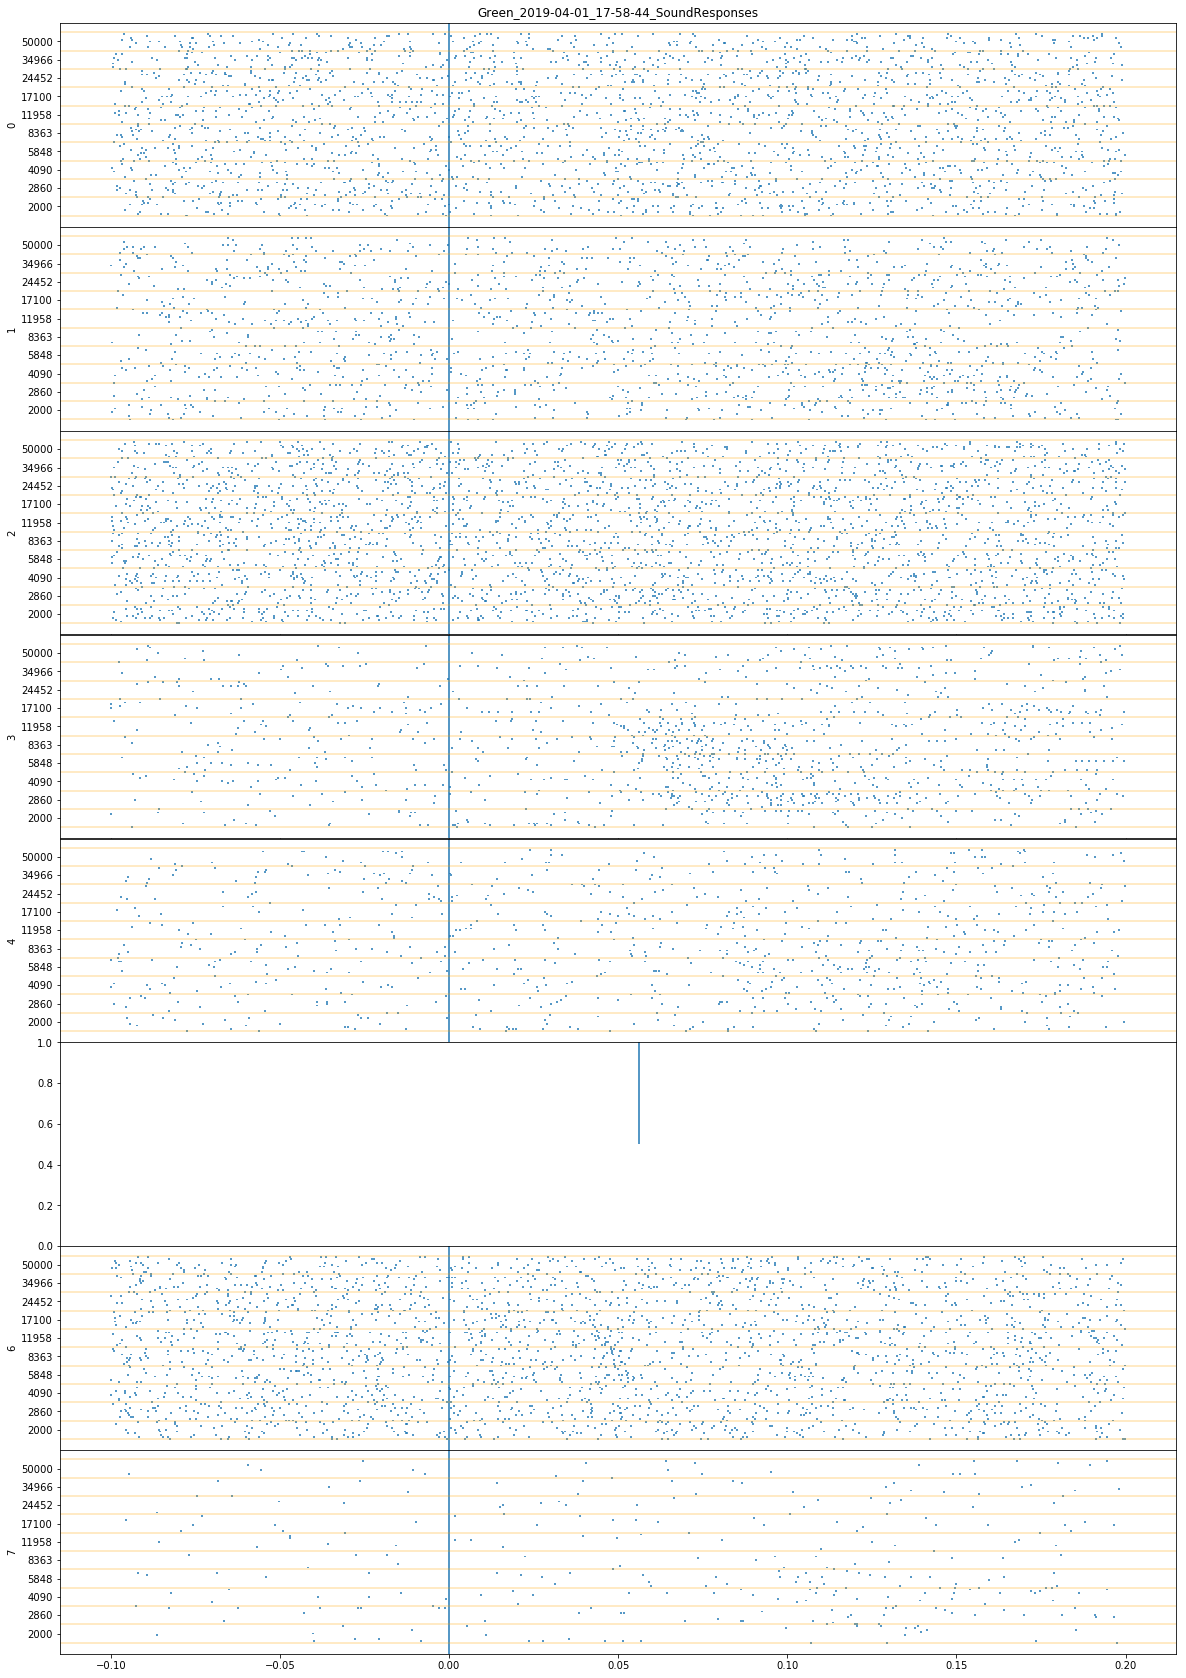

In [30]:
# plot the data
fig_an, ax_an = plt.subplots(len(RasterList),1,figsize=(20, 30), sharex=True)
fig_an.subplots_adjust(hspace = 0.001, wspace=.001)
ax_an = ax_an.ravel()
for i in range(len(RasterList)):
    try:
        ax_an[i].eventplot(RasterList[i])
        axvlines(0, ax = ax_an[i])
        ax_an[i].set_ylabel(i)
        ax_an[i].set_yticks([5,15,25,35,45,55,65,75,85,95])
        ax_an[i].set_yticklabels([2000,2860,4090,5848,8363,11958,17100,24452,34966,50000])
        for j in range(11):
            ax_an[i].axhline(10*j, color = 'orange', alpha = 0.3)
    except:
        print(i)
ax_an[0].set_title(Experiment)
plt.savefig(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '_raster_tetrodes.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [31]:
# calculate the firing rate per tetrode: FiringList[tetrode][SoundID][nPresentation]
FiringList = [None] * len(RasterList)
SilentList = [None] * len(RasterList)
MeansList = [None] * len(RasterList)
StimPresVectorGrouped = [x//10 for x in range(10,110)]

counter = 0
for i in range(len(RasterList)):
    tetrode = RasterList[i]
    FiringList[counter] = np.asarray([sum(np.array(x)>=0) for x in tetrode]) / SecAfterSound
    SilentList[counter] = np.asarray([sum(np.array(x)<0) for x in tetrode]) / SecBeforeSound
    MeansList[counter] = np.insert(np.mean(FiringList[counter].reshape(10,10), axis = 1), 0, np.mean(SilentList[counter]))
    counter += 1

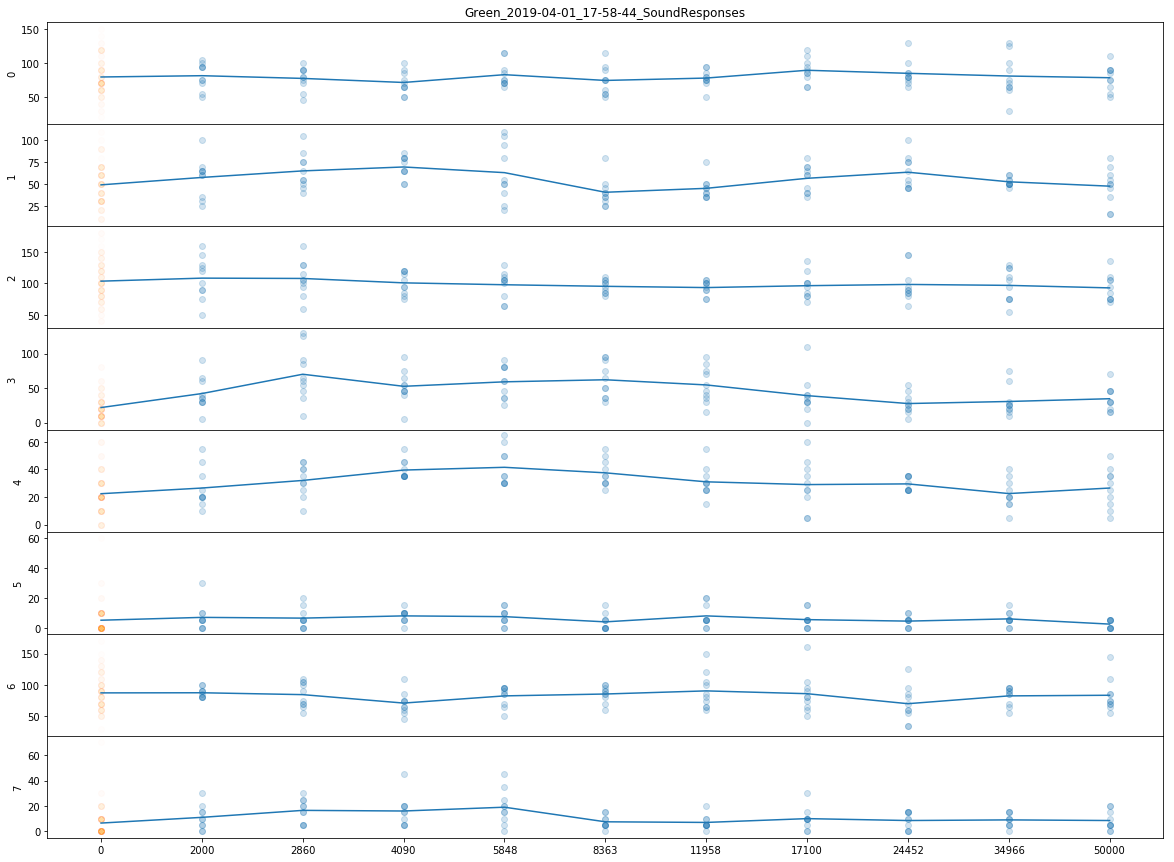

In [32]:
#plot
fig, axs = plt.subplots(len(FiringList), 1, figsize=(20, 15) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = 0.001, wspace=.001)
axs = axs.ravel()

for tetrode in range(len(FiringList)):
    axs[tetrode].scatter(StimPresVectorGrouped, FiringList[tetrode], alpha = 0.2)
    axs[tetrode].scatter([0] * len(SilentList[tetrode]), SilentList[tetrode], alpha = 0.01, color = 'orange')
    axs[tetrode].plot(MeansList[tetrode])
    axs[tetrode].set_ylabel(tetrode)
axs[tetrode].set_xticks([x for x in range(11)])
axs[tetrode].set_xticklabels([0,2000,2860,4090,5848,8363,11958,17100,24452,34966,50000])
axs[0].set_title(Experiment)
plt.savefig(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '_tetrodes.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [33]:
# Calculate the spike count directly FirRate[Channel] = [ ,  ,  , ...] -> spike counts in order of the sound presentation
# Calculate the silent time firing rate
#SecAfterSound = 0.3
FiringRateList = [None] * 32
SilentRateList = [None] * 32
for Channel in range(32):
    FiringRate = [None] * len(stimulus_order)
    SilentRate = [None] * len(stimulus_order)
    for SoundPresentation in range(len(stimulus_order)):
        calcWindowF = range(int(30000*(soundPresentationTimes[SoundPresentation].item())), int(30000*(soundPresentationTimes[SoundPresentation].item()+SecAfterSound)))
        calcWindowS = range(int(30000*(soundPresentationTimes[SoundPresentation].item()-SecAfterSound)), int(30000*(soundPresentationTimes[SoundPresentation].item())))
        FiringRate[SoundPresentation] = len(SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[calcWindowF][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[calcWindowF][-1])]) / SecAfterSound    
        SilentRate[SoundPresentation] = len(SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[calcWindowS][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[calcWindowS][-1])]) / SecAfterSound    
    
    FiringRateList[Channel] = FiringRate
    SilentRateList[Channel] = SilentRate

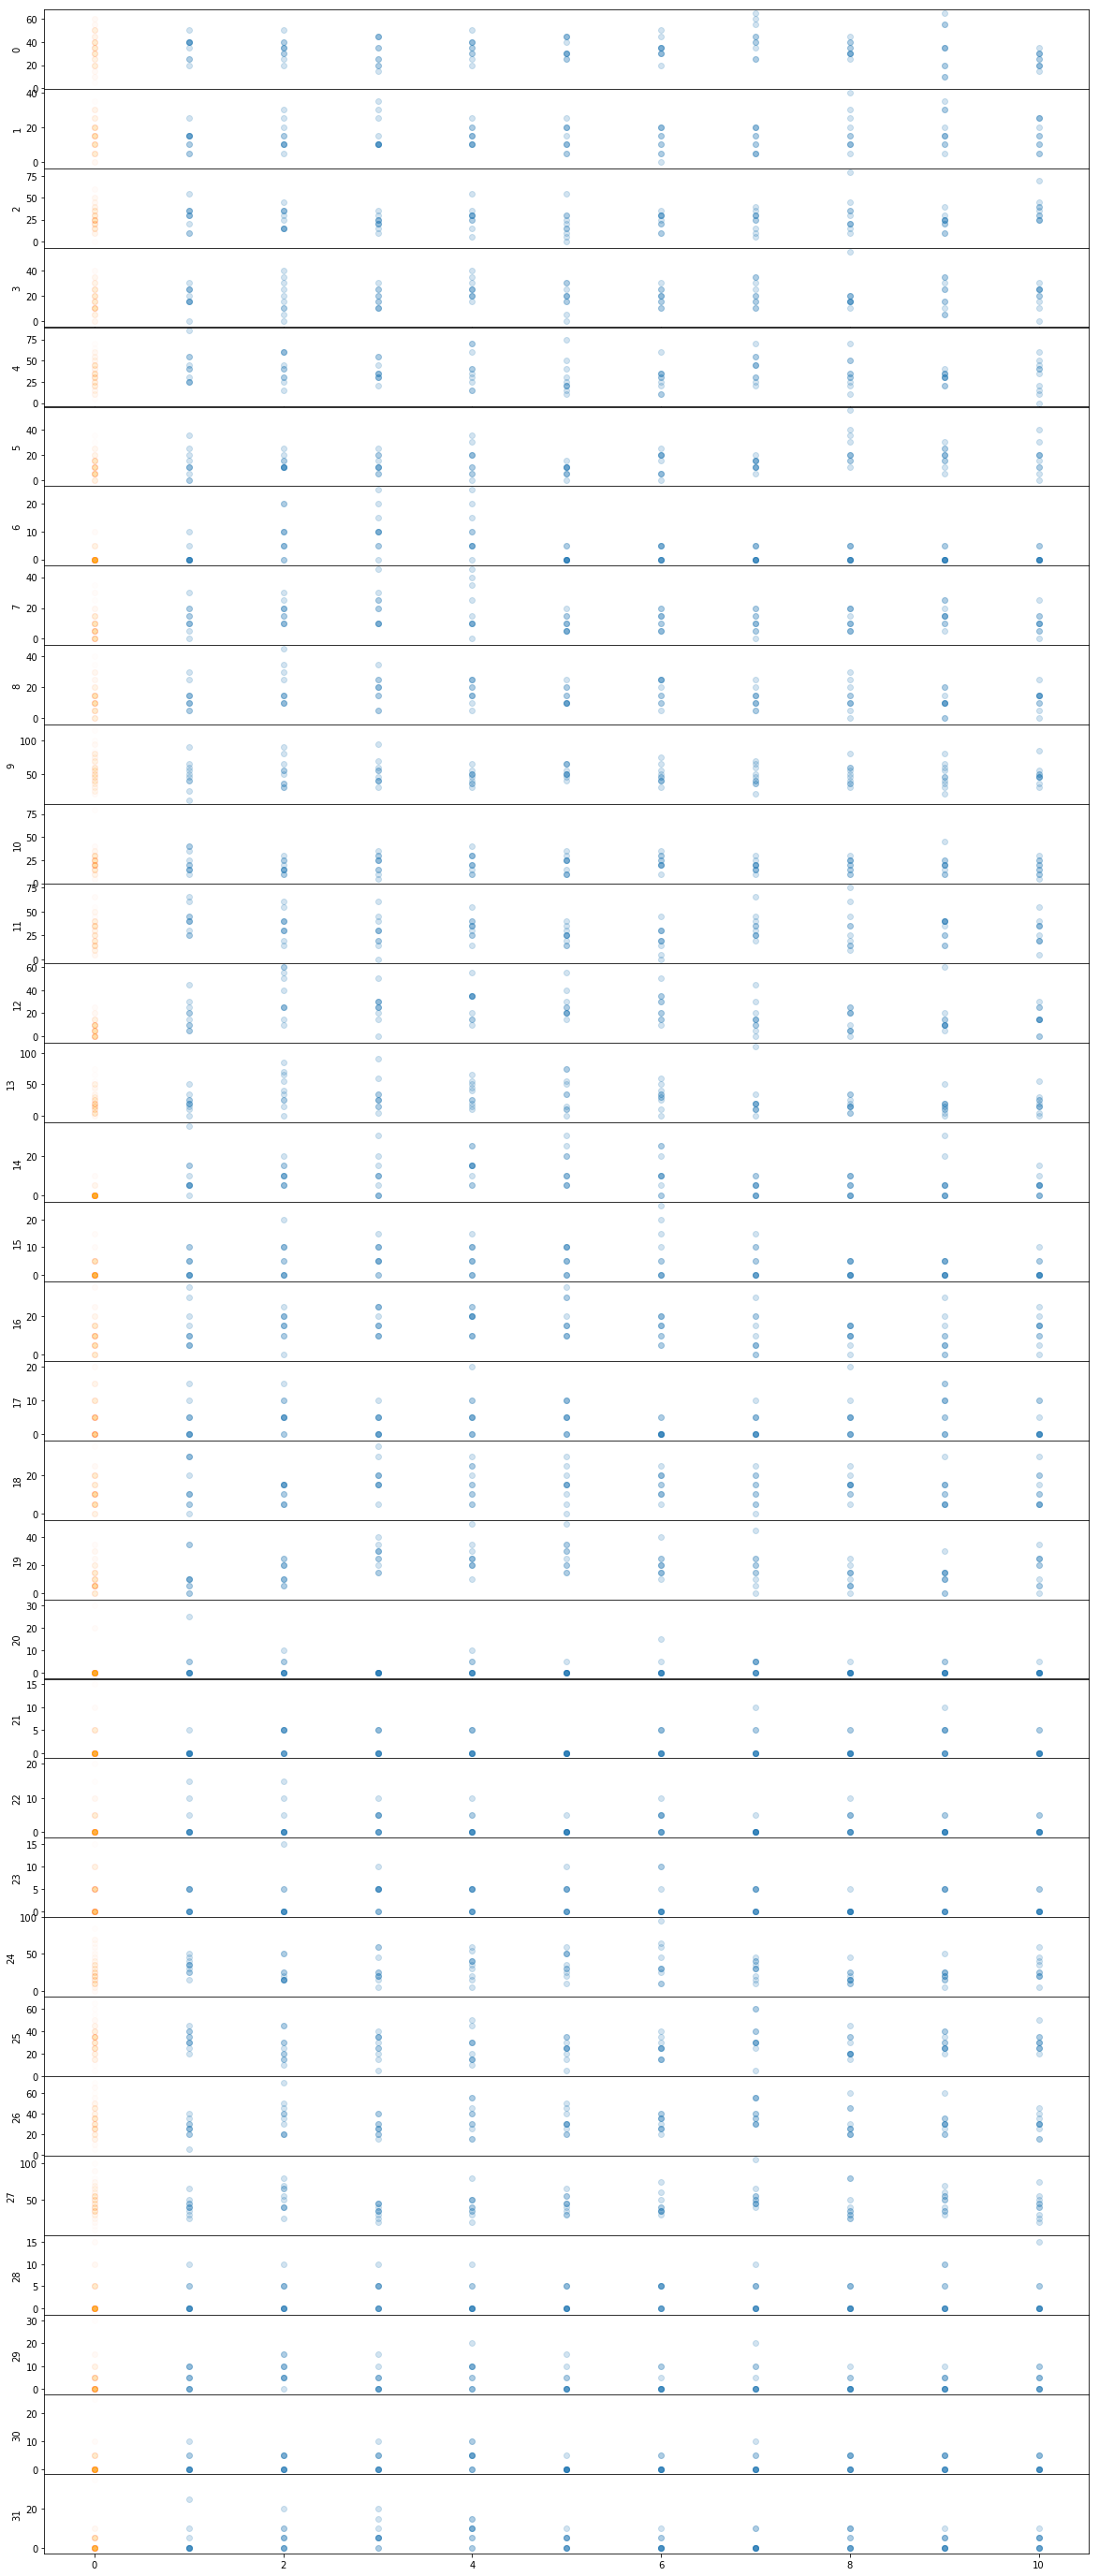

In [34]:
fig, axs = plt.subplots(32, 1, figsize=(20, 50) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = 0.001, wspace=.001)
axs = axs.ravel()

for Channel in range(32):
    axs[Channel].scatter(stimulus_order, FiringRateList[Channel], alpha = 0.2)
    axs[Channel].scatter([0] * len(SilentRateList[Channel]), SilentRateList[Channel], alpha = 0.01, color = 'orange')
    axs[Channel].set_ylabel(Channel)
plt.savefig(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '.pdf', transparent=True, bbox_inches='tight')
plt.show()


###### 